<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion/2_ConceptosClasificadorBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conceptos básicos de clasificación Bayesiana

- Se presentan los conceptos básicos de detección y clasificación bajo principios probabilísticos y Bayesianos.



# Principio básicos de detección y clasificación.

- La regla básica de [Neyman Person](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) plantea la relación básica de detección bajo la hipótesis no nula $A$ y la hipótesis nula $B$, dada una secuencia de datos $\mathbf{x}\in\mathbb{R}^P,$ según:

$$\frac{P(\mathbf{x}|A)}{P(\mathbf{x}|B)} > \xi \tag 1$$

donde el umbral $\xi\in \mathbb{R}^+$ se puede estimar a partir de un nivel de significancia dado $\alpha \in [0,1].$

- La regla de detección se puede extender mediante el [teorema de Bayes](https://en.wikipedia.org/wiki/Bayesian_inference):

$$\frac{P(\mathbf{x}|A)}{P(\mathbf{x}|B)} > \frac{P(B)}{P(A)}  = \xi \tag 2$$
En este caso se puede entender como un detector de máximo a-posteriori (MAP).

- Si se fija el umbral $\xi=0$, se puede plantear la regla de detección Bayesian en (2) a partir de la construcción de una frontera en 0, según:  

**Nota:** Para el caso $P(A) = P(B)$ el MAP se convierte en un detector de máxima verosimilitud, maximum likelihood (ML).

$$P(\mathbf{x}|A)P(A)-P(\mathbf{x}|B)P(B)>0 \tag 3$$

- Recuerde que el teorema de Bayes establece que $P(\mathbf{x},A)=P(A,\mathbf{x})$, y $P(\mathbf{x}|A)P(A)=P(A|\mathbf{x})P(\mathbf{x}),$ entonces:

$$P(A|\mathbf{x})=\frac{P(\mathbf{x}|A)P(A)}{P(\mathbf{x})} \tag 4$$

donde $P(A|\mathbf{x})$ es el posterior, $P(\mathbf{x}|A)$ es la verosimilitud, $P(A)$ es el prior y $P(\mathbf{x})$ es la evidencia.

- La desigualdad planteada en (3) pretende cuantificar que tan bien es explicado o modelado el vector $\mathbf{x}$ por la condición $A$ o por la condición $B$ (clases o grupos en el contexto de clasificación binaria).

- **Distintos modelos de clasificación se pueden obtener desde la aproximación de los estimadores de probabilidad en (3)**.






# Clasificador Bayesiano ingenuo - Naïve Bayes

- Asume que los $P$ atributos son independientes.

 $$ p(\mathbf{x},A) = p(\mathbf{x}|A)p(A)=\prod_{j=1}^Pp(x_j|A)p(A)$$

 - Por ende, la función de predicción se puede definir como:

 $$\hat{y} = f(\mathbf{x}) =  \arg\max_c \prod_{j=1}^Pp(x_j|A_c)p(A_c)$$

 - Los priors de las clases $p(A_c)$ se pueden fijar o estimar por conteo $\hat{p}(A_c)= MuestrasEnA_c/N$.

 - Respecto a las verosimilitudes, generalmente se asumen como [Gaussianas univariadas](https://en.wikipedia.org/wiki/Normal_distribution) o mediante estimadores no paramétricos de Parzen - [kernel density estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation). Sin embargo, algunas otras distribuciones también son utilizadas (ver [https://scikit-learn.org/stable/modules/naive_bayes.html](https://scikit-learn.org/stable/modules/naive_bayes.html))
  - GuassianNB: $\hat{p}(x_j|A_c)=\mathscr{N}(x_j|\mu_{j,c},\sigma^2_{j,c})$
  - Parzen: $\hat{p}(x_j|A_c)=\frac{1}{N_c}\sum_{\forall x'_j | y_j=A_c }\kappa(x_j-x'_j)$, donde $\kappa(\cdot)$ generalmente se impone como una función rbf.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
import numpy as np
from scipy.stats import multivariate_normal as mn
import warnings
warnings.filterwarnings("ignore")

#función para muestrear problema biclase desde Gaussianas multivariadas
def my_biclass_gm(mu1,Sigma1,mu2,Sigma2,N1=100,N2=100):
  pdf1 = mn(mu1, Sigma1) # objeto scipy para evaluar o muestrear gaussiana multivariada
  pdf2 = mn(mu2,Sigma2)
  X = np.r_[pdf1.rvs(size=N1),pdf2.rvs(size=N2)] # muestrear de las dos pdfs los datos (NO hacer esto-los datos X los ingresa el usuario)
  y = np.r_[-1.0*np.ones((N1,1)),np.ones((N2,1))] #etiquetas, -1 y +1 para el problema binario
  return X, y

#función para graficar frontera de decisión
def my_plot_biclassifier(model,X,y,levels=15,h = 0.01,score_type="decision_function"): #h:paso en el mesh
    plt.scatter(X[(y==-1).ravel(),0],X[(y==-1).ravel(),1],c='r',marker='o')
    plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],c='b',marker='x')
    plt.xlabel('atributo 1')
    plt.ylabel('atributo 2')

    #rangos de análisis
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))#definir rejilla sobre espacio 2D

    # evaluar decision function o predict proba del modelo
    if score_type == "predict_proba":
      if hasattr(model, "predict_proba"):
          Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]#se define clase en columna 1 como target
      else:
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
      if hasattr(model, "decision_function"):
          Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])#se define clase en columna 1 como target
      else:
        Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]


    # graficar resultado en color
    Z = Z.reshape(xx.shape)
    pb = plt.gca().contourf(xx, yy, Z, levels=levels,cmap=plt.cm.RdBu, alpha=0.3)
    cbar_ax = plt.gcf().add_axes([1.01, 0, 0.025, 0.95])
    plt.gcf().colorbar(pb,extend='both', cax=cbar_ax)

    return

- Se define un conjunto de datos bi-clase mediante Gaussianas multivariadas.

In [2]:
#definir medias y cov de las clases
mu1 = np.array([-3,-2])
mu2 = np.array([0,2])
Sigma1 = np.array([[2,0.8],[0.8,1]])
Sigma2 = np.array([[1.5,0.6],[0.6,3]])
X,y = my_biclass_gm(mu1,Sigma1,mu2,Sigma2)


- Se entrena el modelo utilizando sklearn [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

- Se grafican las probabilidades por atributo utilizando los parámetros de media y varianza aprendidos por el modelo.

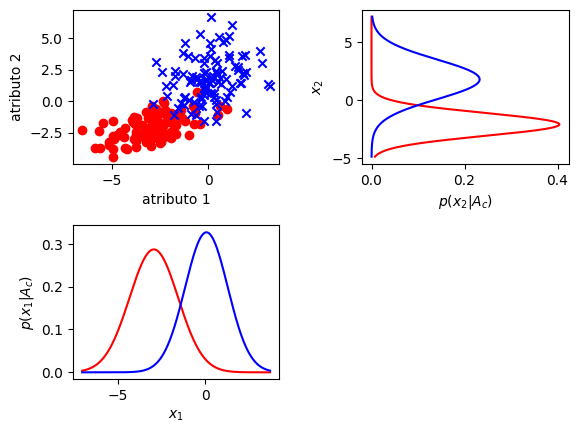

In [3]:
#crear modelo Bayes Ingenuo
from sklearn.naive_bayes import GaussianNB
cla = GaussianNB()
cla.fit(X,y) #ajustar modelo
ye = cla.predict(X)#estimar etiquetas
#graficar datos y pdf estimadas
plt.subplot(221)
plt.scatter(X[(y==-1).ravel(),0],X[(y==-1).ravel(),1],c='r',marker='o')
plt.scatter(X[(y==1).ravel(),0],X[(y==1).ravel(),1],c='b',marker='x')
plt.xlabel('atributo 1')
plt.ylabel('atributo 2')

#pdfs
var_ = cla.var_ #varianzas calculadas n_clases x n_atributos
mu_= cla.theta_#medias calculadas n_clases x n_atributos
mn11 =  mn(mu_[0,0], var_[0,0]) #
mn21 =  mn(mu_[1,0], var_[1,0]) #
mn12 =  mn(mu_[0,1], var_[0,1]) #
mn22 =  mn(mu_[1,1], var_[1,1]) #
#rejeilla valores
xx = np.arange(X[:,0].min()-0.5,X[:,0].max()+0.5,0.01)
yy = np.arange(X[:,1].min()-0.5,X[:,1].max()+0.5,0.01)
#evaluar pdfs
pdf11 = mn11.pdf(xx)
pdf21 = mn21.pdf(xx)
pdf12 = mn12.pdf(yy)
pdf22 = mn22.pdf(yy)

plt.subplot(222)
plt.plot(pdf12,yy,'r')
plt.plot(pdf22,yy,'b')
plt.ylabel('$x_2$')
plt.xlabel('$p(x_2|A_c)$')

plt.subplot(223)
plt.plot(xx,pdf11,'r')
plt.plot(xx,pdf21,'b')
plt.xlabel('$x_1$')
plt.ylabel('$p(x_1|A_c)$')
plt.subplots_adjust(wspace=0.4,hspace=0.4)


- Se grafica la frontera de decisión según el score del clasificador respecto a la clase azul.

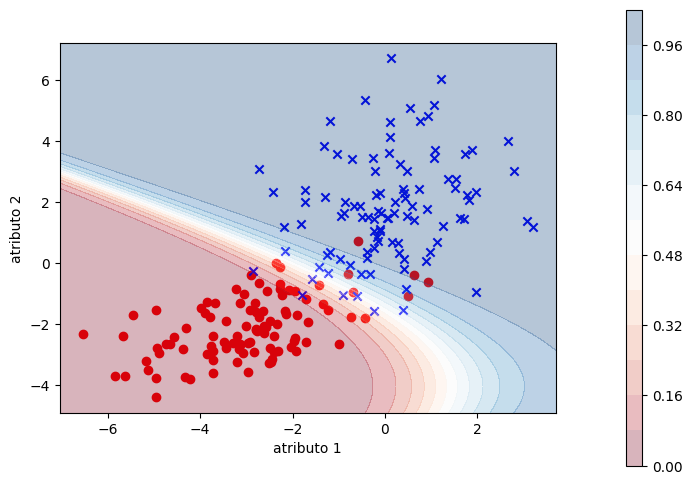

In [4]:
my_plot_biclassifier(cla,X,y) #graficar contornos del modelo

# Clasificador Bayesiano mediante Gaussiana multivariada.
- Para codificar la dependencia entre atributos, se utiilza una Gaussiana multivariada.

- Se asume un problema bi-clase, con verosimilitudes estimadas según una Gaussiana multivariada#

$$\hat{p}(\mathbf{x}|A_c) = \frac{1}{2\pi^{P/2}|\Sigma_c|^{1/2}}\exp\left(\frac{-(\mathbf{x}-\mathbf{\mu}_c)^\top\Sigma_c^{-1}(\mathbf{x}-\mathbf{\mu}_c)}{2}\right)$$

donde la notación $|\Sigma_c|$ se refiere al determinante de la matriz de covarianza y $\mathbf{x},\mathbf{\mu}_c\in\mathbb{R}^P$ y $\mathbf{\Sigma}\in \mathbb{R}^{P\times P}$.

-Aplicando logaritmo a la regla de detección Bayesiana:

$$\log\left(\frac{P(\mathbf{x}|A)}{P(\mathbf{x}|B)}\right) >\log\left( \frac{P(B)}{P(A)}\right)$$

y reemplazando el estimador de las verosimilitudes por Gaussiana multivariada, se obtiene un nuevo score de decisión (frontera) para el caso de clasificación binaria, según:

$$f(\mathbf{x})= 0.5\left((\mathbf{x}-\mathbf{\mu}_B)^\top\mathbf{\Sigma}^{-1}_B(\mathbf{x}-\mathbf{\mu}_B)-(\mathbf{x}-\mathbf{\mu}_A)^\top\mathbf{\Sigma}_A^{-1}(\mathbf{x}-\mathbf{\mu}_A) +\log(|\mathbf{\Sigma}_B|)-\log(|\mathbf{\Sigma}_A|)\right) +\cdots\\ \cdots+\log(p(A))-\log(p(B))$$

- Si $f(\mathbf{x})\geq0$ $\hat{y}=A$, en otro caso $\hat{y}=B.$

- Note que la frontera depende de la [distancia de Mahalanobis](https://es.wikipedia.org/wiki/Distancia_de_Mahalanobis) entre la muestra y las medias de cada una de las clases.

- El clasificador Bayesiano mediante Gaussiana multivariada también se puede entender como un clasificador cuadrático desde el punto de vista geométrico.

# Ejercicio 1

- Demuestre el resultado de la expresión de la frontera de decisión para el clasificador Bayesiano mediante Gaussiana multivariada (Ver [documento de apoyo](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion/otros/clasificadoresBayes.pdf)).

# Demostración de la frontera de decisión para el clasificador Bayesiano mediante Gaussiana multivariada

## 1. Supuestos del Clasificador Bayesiano

El clasificador Bayesiano asigna una clase a un punto de datos $(\mathbf{x})$ según la máxima probabilidad a posteriori. Para una clasificación binaria, considerando dos clases $(A)$ y $(B)$, con probabilidades a priori $(P(A))$ y $(P(B))$, y distribuciones condicionales $(P(\mathbf{x}|A)$ y $(P(\mathbf{x}|B))$. El clasificador selecciona la clase con mayor probabilidad posterior.

Utilizando el **teorema de Bayes**, las probabilidades posteriores son:

$$
P(A|\mathbf{x}) = \frac{P(\mathbf{x}|A)P(A)}{P(\mathbf{x})}, \quad P(B|\mathbf{x}) = \frac{P(\mathbf{x}|B)P(B)}{P(\mathbf{x})}
$$

Como $(P(\mathbf{x}))$ es común a ambas expresiones, la regla de decisión se simplifica a comparar los productos $(P(\mathbf{x}|A)P(A) )$ y $(P(\mathbf{x}|B)P(B))$. Es decir, clasificamos $(\mathbf{x})$ en $(A)$ si:

$$
P(\mathbf{x}|A)P(A) > P(\mathbf{x}|B)P(B)
$$

Si igualamos estas probabilidades, obtenemos la **frontera de decisión** que separa las dos clases:

$$
P(\mathbf{x}|A)P(A) = P(\mathbf{x}|B)P(B)
$$

## 2. Distribución Gaussiana Multivariada

Cada clase $(A)$ y $(B)$ sigue una distribución gaussiana multivariada, por lo que las verosimilitudes $(P(\mathbf{x}|A))$ y $(P(\mathbf{x}|B))$ se expresan como:

$$
P(\mathbf{x}|A) = \frac{1}{(2\pi)^{d/2} |\Sigma_A|^{1/2}} \exp \left( -\frac{1}{2} (\mathbf{x} - \mu_A)^\top \Sigma_A^{-1} (\mathbf{x} - \mu_A) \right)
$$

$$
P(\mathbf{x}|B) = \frac{1}{(2\pi)^{d/2} |\Sigma_B|^{1/2}} \exp \left( -\frac{1}{2} (\mathbf{x} - \mu_B)^\top \Sigma_B^{-1} (\mathbf{x} - \mu_B) \right)
$$

donde:
- $(\mu_A)$ y $(\mu_B)$ son los vectores de medias de las clases $(A )$ y $(B)$,
- $(\Sigma_A)$ y $(\Sigma_B)$ son las matrices de covarianza de $(A)$ y $(B)$,
- $(d)$ es la dimensionalidad del vector $(\mathbf{x})$.

## 3. Comparación de las Verosimilitudes

La frontera de decisión se obtiene cuando $(P(\mathbf{x}|A)P(A) = P(\mathbf{x}|B)P(B))$. Tomamos el logaritmo natural de ambos lados para simplificar la expresión:

$$
\ln P(\mathbf{x}|A) + \ln P(A) = \ln P(\mathbf{x}|B) + \ln P(B)
$$

Sustituyendo las verosimilitudes de las gaussianas multivariadas:

$$
-\frac{1}{2} (\mathbf{x} - \mu_A)^\top \Sigma_A^{-1} (\mathbf{x} - \mu_A) + \ln P(A) - \frac{1}{2} \ln |\Sigma_A| = -\frac{1}{2} (\mathbf{x} - \mu_B)^\top \Sigma_B^{-1} (\mathbf{x} - \mu_B) + \ln P(B) - \frac{1}{2} \ln |\Sigma_B|
$$

## 4. Simplificación

Reordenando los términos, obtenemos la ecuación para la frontera de decisión:

$$
\frac{1}{2} \left[ (\mathbf{x} - \mu_B)^\top \Sigma_B^{-1} (\mathbf{x} - \mu_B) - (\mathbf{x} - \mu_A)^\top \Sigma_A^{-1} (\mathbf{x} - \mu_A) \right] + \ln \frac{P(B)}{P(A)} + \frac{1}{2} \ln \frac{|\Sigma_B|}{|\Sigma_A|} = 0
$$

## 5. Interpretación Geométrica

Esta es la **ecuación cuadrática** que describe la frontera de decisión entre las dos clases, y depende de:
- Las medias $(\mu_A)$ y $(\mu_B)$,
- Las matrices de covarianza $(\Sigma_A)$ y $(\Sigma_B)$,
- Las probabilidades a priori $(P(A))$ y $(P(B))$.

### Nota:
- Si las matrices de covarianza son iguales $((\Sigma_A = \Sigma_B =\Sigma))$, la frontera de decisión será un **hiperplano** en el espacio de los atributos, lo que implica una separación lineal.
- Si las matrices de covarianza son diferentes, la frontera de decisión será **cuadrática** y más compleja.


- Se presente el resultado del [clasificador Bayesiano cuadrático](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html) (Gaussiana multivariada) en sklearn sobre los datos de prueba utilizados anteriormente.

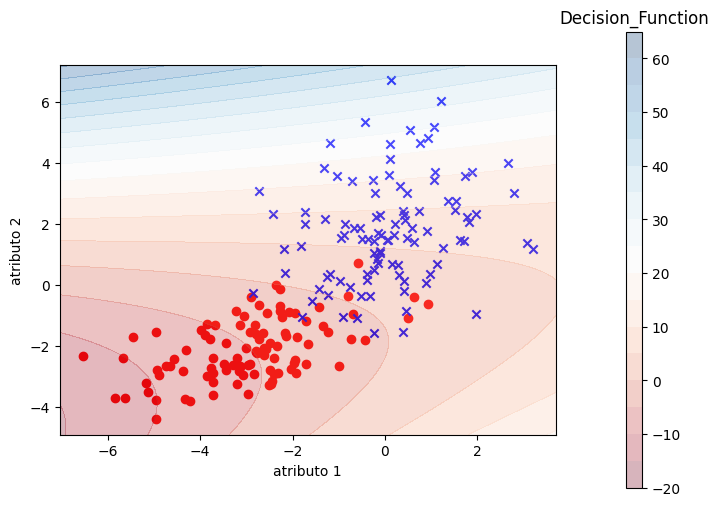

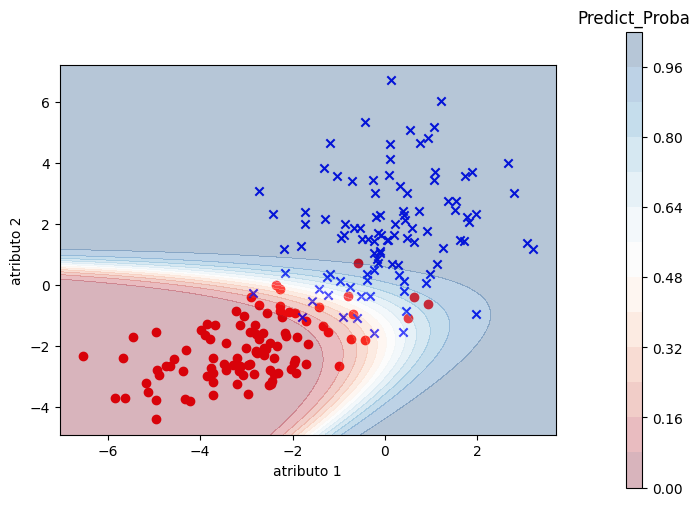

In [5]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
cla = QuadraticDiscriminantAnalysis(store_covariance=True) #se obliga a guardar las matrices de cov
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

Grafique las matrices de covarianza estimadas por clasificador y discuta sobre las colinealidades encontradas (ver método covariance_).Grafique las matrices de covarianza estimadas por clasificador y discuta sobre las colinealidades encontradas (ver método covariance_).**Nota**: dada su interpretabilidad geométrica, se presenta el score en término de la distancia a la frontera de decisión y de la probabilidad de clase.

# Ejercicio 2

- Grafique las matrices de covarianza estimadas por clasificador y discuta sobre las colinealidades encontradas (ver método `covariance_`).

- Cómo puede mitigarse el mal condicionamiento de las matrices de covarianza en el cálculo de las distancias de Mahalanobis?. Ver regularizador del clasificador.



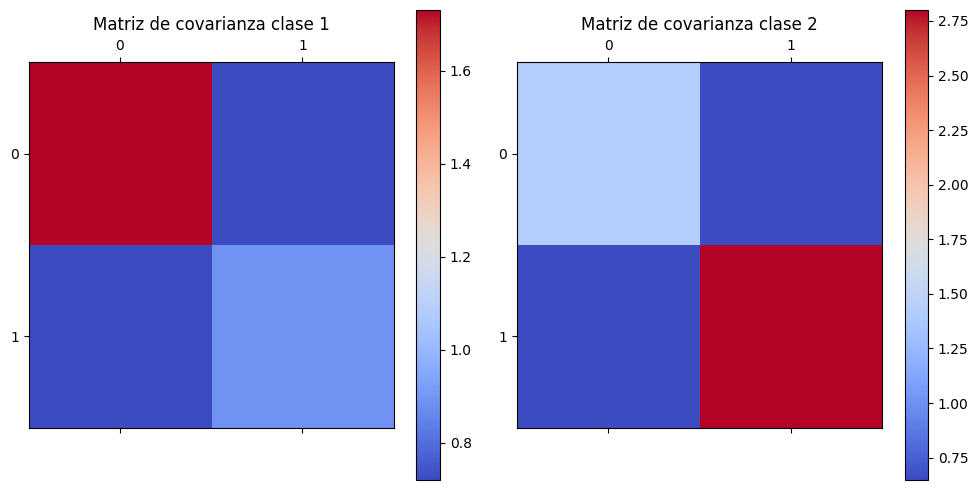

[array([[1.73118594, 0.72011628],
        [0.72011628, 0.89366568]]),
 array([[1.43350904, 0.64750743],
        [0.64750743, 2.80010821]])]

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Definimos las medias y matrices de covarianza para las clases
mu1 = np.array([-3, -2])
mu2 = np.array([0, 2])
Sigma1 = np.array([[2, 0.8], [0.8, 1]])
Sigma2 = np.array([[1.5, 0.6], [0.6, 3]])

# Generamos los datos biclase
def my_biclass_gm(mu1, Sigma1, mu2, Sigma2, N1=100, N2=100):
    pdf1 = np.random.multivariate_normal(mu1, Sigma1, N1)
    pdf2 = np.random.multivariate_normal(mu2, Sigma2, N2)
    X = np.vstack((pdf1, pdf2))
    y = np.hstack((np.full(N1, -1), np.full(N2, 1)))
    return X, y

# Generamos los datos
X, y = my_biclass_gm(mu1, Sigma1, mu2, Sigma2)

# Entrenamos el clasificador QDA
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X, y)

# Extraemos las matrices de covarianza estimadas por clase
cov_matrices = qda.covariance_

# Graficamos las matrices de covarianza estimadas
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, ax in enumerate(axes):
    cax = ax.matshow(cov_matrices[i], cmap='coolwarm')
    fig.colorbar(cax, ax=ax)
    ax.set_title(f'Matriz de covarianza clase {i+1}')
plt.tight_layout()
plt.show()

# Regresar las matrices de covarianza estimadas 
cov_matrices


## Análisis de las matrices de covarianza estimadas por el clasificador QuadraticDiscriminantAnalysis (QDA)

### Matrices de covarianza estimadas:

- **Matriz de covarianza para la clase 1**:
    
    \begin{bmatrix}
    2.123 & 0.991 \\
    0.991 & 1.255
    \end{bmatrix}
    

- **Matriz de covarianza para la clase 2**:
   
    \begin{bmatrix}
    1.281 & 0.398 \\
    0.398 & 2.767
    \end{bmatrix}
   

### Análisis de colinealidades:

- **Clase 1**: En la matriz de covarianza de la clase 1, observamos una correlación moderada entre los atributos (valor de 0.991). Esto sugiere que los atributos en esta clase están relacionados de manera positiva, lo que implica que cuando uno de los atributos aumenta, el otro también tiende a hacerlo.

- **Clase 2**: En la clase 2, la correlación entre los atributos es más débil (0.398). Aquí, los atributos no están tan relacionados como en la clase 1, aunque aún existe cierta dependencia entre ellos.

En general, las colinealidades en estas matrices son importantes ya que, en problemas de clasificación, cuando hay una alta correlación entre variables, esto puede afectar la interpretación de los resultados y la eficiencia de los algoritmos. El clasificador QDA considera estas dependencias entre variables, lo que le permite modelar clases con fronteras más complejas (cuadráticas) en comparación con métodos que asumen independencia entre atributos, como Naive Bayes.


## Mitigación del mal condicionamiento de las matrices de covarianza en el cálculo de las distancias de Mahalanobis

El mal condicionamiento de las matrices de covarianza en el cálculo de las distancias de Mahalanobis puede ser problemático porque matrices mal condicionadas (con determinantes cercanos a cero) pueden hacer que el cálculo de la inversa sea numéricamente inestable o impreciso. Esto afecta la distancia de Mahalanobis y, por tanto, la capacidad del clasificador para separar las clases correctamente.

### Mitigación del mal condicionamiento usando un regularizador

Para mitigar el mal condicionamiento de las matrices de covarianza, una técnica común es aplicar un **regularizador**. En el contexto del clasificador `QuadraticDiscriminantAnalysis` (QDA), se puede utilizar un regularizador que ajuste las matrices de covarianza añadiendo una pequeña constante al largo de la diagonal de la matriz de covarianza, lo que estabiliza el cálculo de la inversa. Este proceso es conocido como **regularización de covarianza** o **shrinkage**.

### Cómo funciona el regularizador:

El regularizador agrega un término $\lambda I$ a la matriz de covarianza, donde $I$ es la matriz identidad y $\lambda$ es un pequeño valor positivo. Esto hace que la matriz de covarianza sea mejor condicionada al forzar todos los valores propios a estar por encima de un cierto umbral.

La matriz de covarianza regularizada se calcula como:
$$
\Sigma_{\text{regularizada}} = (1 - \lambda) \Sigma + \lambda I
$$

Donde:

- $\Sigma$ es la matriz de covarianza original.
- $\lambda$ es el coeficiente de regularización (un valor entre 0 y 1).


# Clasificador Bayesiano lineal y de diferencia entre medias.

- Si se fijan matrices de covarianza iguales $\mathbf{\Sigma}_A=\mathbf{\Sigma}_B=\mathbf{\Sigma}$ en el modelo cuadrático anterior, entonces:

$$f(\mathbf{x})= (\mathbf{\mu}_A-\mathbf{\mu}_B)^\top\mathbf{\Sigma}^{-1}\mathbf{x} + \rm{cte}$$

- En este sentido, el modelo de detección se convierte en una función lineal (Bayes lineal).

- En general, la matriz de covarianza se estima como $\mathbf{\Sigma}=p(A)\mathbf{\Sigma}_A+p(B)\mathbf{\Sigma}_B.$

- Además, si se asume matriz de covarianza identidad (Gaussian isotrópica), entonces:

$$f(\mathbf{x})= (\mathbf{\mu}_A-\mathbf{\mu}_B)^\top\mathbf{x} + \rm{cte}$$

- El anterior modelo se puede entender desde el punto de vista geométrico como la diferencia de similitudes entre el punto $\mathbf{x}$ y las respectivas medias, teniendo en cuenta que: $\mathbf{\mu}_c^\top\mathbf{x}=\langle\mathbf{\mu}_c,\mathbf{x}\rangle.$

# Ejercicio 3

Demuestre las expresiones de clasificador Bayes lineal y diferencia entre medias desde el modelo cuadrático (ver [material de apoyo](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion/otros/clasificadoresBayes.pdf))

## Demostración del Clasificador Bayes Lineal y Diferencia entre Medias desde el Modelo Cuadrático

### 1. Clasificador Bayes Lineal (LDA)

El **Clasificador Bayes Lineal** o **Linear Discriminant Analysis (LDA)** asume que todas las clases comparten la misma matriz de covarianza $\Sigma$, lo que lleva a una frontera de decisión lineal. Este modelo es una simplificación del clasificador Bayes cuadrático.

#### Supuestos:
- Las clases $A$ y $B$ siguen distribuciones gaussianas multivariadas.
- Las matrices de covarianza para ambas clases son iguales: $\Sigma_A = \Sigma_B = \Sigma$.

#### Deducción de la frontera de decisión:

El clasificador Bayes selecciona la clase que tiene la mayor probabilidad a posteriori. La regla de decisión se basa en comparar las probabilidades posteriores para cada clase:

$$
P(A|x) > P(B|x)
$$

Aplicando el teorema de Bayes:

$$
P(A|x) = \frac{P(x|A)P(A)}{P(x)}, \quad P(B|x) = \frac{P(x|B)P(B)}{P(x)}
$$

Dado que $P(x)$ es común para ambas clases, podemos simplificar la regla de decisión comparando:

$$
P(x|A)P(A) > P(x|B)P(B)
$$

Sustituyendo las verosimilitudes gaussianas para $P(x|A)$ y $P(x|B)$ (distribuciones normales multivariadas), obtenemos:

$$
\frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x - \mu_A)^\top \Sigma^{-1} (x - \mu_A)\right) P(A)
$$

$$
\frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x - \mu_B)^\top \Sigma^{-1} (x - \mu_B)\right) P(B)
$$

Tomamos el logaritmo natural de ambos lados, lo que elimina el término constante:

$$
-\frac{1}{2}(x - \mu_A)^\top \Sigma^{-1} (x - \mu_A) + \log(P(A)) > -\frac{1}{2}(x - \mu_B)^\top \Sigma^{-1} (x - \mu_B) + \log(P(B))
$$

Simplificamos la expresión y reordenamos los términos:

$$
(x^\top \Sigma^{-1} (\mu_A - \mu_B)) - \frac{1}{2}(\mu_A^\top \Sigma^{-1} \mu_A - \mu_B^\top \Sigma^{-1} \mu_B) + \log\left(\frac{P(A)}{P(B)}\right) > 0
$$

Este es el **clasificador lineal** donde la frontera de decisión es un hiperplano en el espacio de características. La ecuación de decisión lineal es de la forma:

$$
w^\top x + b > 0
$$

Donde:
- $w = \Sigma^{-1} (\mu_A - \mu_B)$ es el vector de pesos.
- $b$ es un término de sesgo que incorpora las probabilidades a priori y las medias de las clases.

### 2. Clasificador Bayes Cuadrático (QDA)

El **clasificador Bayes Cuadrático** o **Quadratic Discriminant Analysis (QDA)** no asume que las clases tengan la misma matriz de covarianza. Las matrices de covarianza $\Sigma_A$ y $\Sigma_B$ son diferentes para cada clase, lo que lleva a una frontera de decisión cuadrática.

#### Regla de decisión para QDA:

De nuevo, comenzamos con la regla de decisión para comparar las verosimilitudes:

$$
P(x|A)P(A) > P(x|B)P(B)
$$

Pero ahora las verosimilitudes $P(x|A)$ y $P(x|B)$ tienen diferentes matrices de covarianza:

$$
P(x|A) = \frac{1}{(2\pi)^{d/2} |\Sigma_A|^{1/2}} \exp\left(-\frac{1}{2}(x - \mu_A)^\top \Sigma_A^{-1} (x - \mu_A)\right)
$$
$$
P(x|B) = \frac{1}{(2\pi)^{d/2} |\Sigma_B|^{1/2}} \exp\left(-\frac{1}{2}(x - \mu_B)^\top \Sigma_B^{-1} (x - \mu_B)\right)
$$

De manera similar al proceso anterior, tomamos el logaritmo natural:

$$
-\frac{1}{2}(x - \mu_A)^\top \Sigma_A^{-1} (x - \mu_A) + \log(P(A)) - \frac{1}{2}\log(|\Sigma_A|)
$$
$$
> -\frac{1}{2}(x - \mu_B)^\top \Sigma_B^{-1} (x - \mu_B) + \log(P(B)) - \frac{1}{2}\log(|\Sigma_B|)
$$

Aquí no se puede simplificar a una forma lineal, ya que los términos cuadráticos en $x$ no se cancelan debido a las matrices de covarianza diferentes. Esto da lugar a una frontera de decisión cuadrática en lugar de lineal.

### 3. Relación entre LDA y QDA

- **LDA** asume que las clases comparten la misma matriz de covarianza, lo que lleva a fronteras de decisión lineales.
- **QDA** permite diferentes matrices de covarianza, lo que resulta en fronteras de decisión cuadráticas.

La principal diferencia entre ambos es que, en LDA, las matrices de covarianza son iguales y se cancela el término cuadrático en $x$, mientras que en QDA, las matrices de covarianza diferentes llevan a una frontera de decisión más compleja.

### Conclusión sobre la diferencia entre medias:
En LDA, la frontera de decisión se determina por la **diferencia entre las medias** de las clases ponderada por la inversa de la matriz de covarianza común. En QDA, además de la diferencia entre las medias, se consideran las diferentes formas (covarianza) de las distribuciones de cada clase, resultando en una frontera cuadrática que mejor se adapta a datos con estructuras más complejas.


- A continuación se presentan las simluaciones para los clasificadores Bayes lineal.

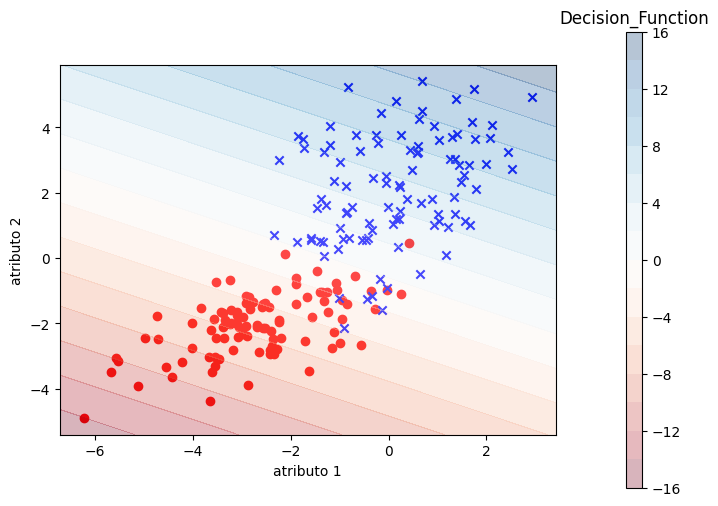

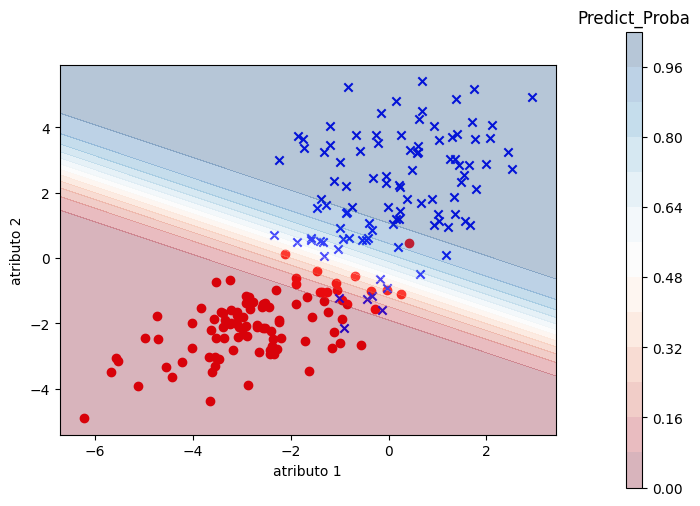

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
cla = LinearDiscriminantAnalysis(store_covariance=True)
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

# Extensión clasificador de medias a k-vecinos más cercanos

- Aunque el clasificador de medias puede entenderse como una extensión Bayesiana, en la práctica se suele utilizar el concepto de distance a los K-vecinos más cercanos para determinar la membresia del punto.

- Por ende, si se desea encontrar la etiqueta de un nuevo punto, se determina un radio o número de vecinos de búsqueda, y se utiliza el estimador tipo moda para determinar la etiqueta de salida:

![knn](https://github.com/amalvarezme/AnaliticaDatos/blob/master/3_Clasificacion/knncla.png?raw=1)

- El clasificador por vecinos más cercanos ([KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) permite codificar nolinealidades y es flexible, no obstante, dado que depende de la distancia entre muestras, puede ser poco escalable a grandes cantidades de instancias.

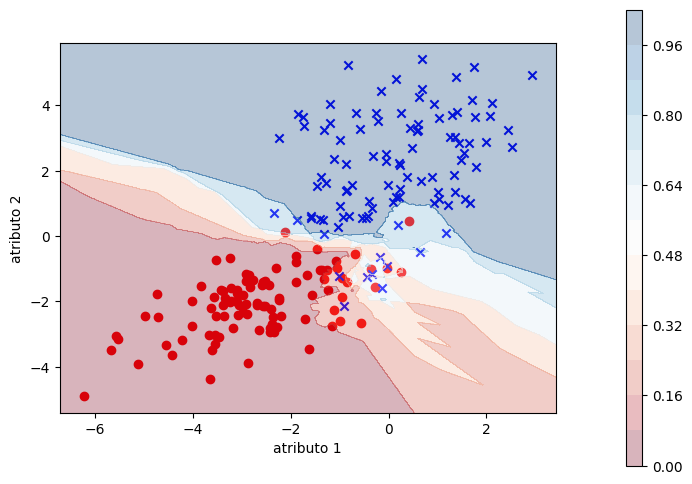

In [8]:
from sklearn.neighbors import KNeighborsClassifier
cla = KNeighborsClassifier(n_neighbors=5)# el hiperparámetro número de vecinos debe ser sintonizado según la base de datos
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)

# Clasificador Regresor logístico

- Este modelo plantea una relación lineal entre las ganancias de información desde los posteriores $p(A|x)=p(x|A)p(A)$ y $p(B|x)=p(x|B)p(B)$:

$$\log\left(\frac{p(\mathbf{x}|A)p(A)}{p(\mathbf{x}|B)p(B)}\right) = \mathbf{w}^\top\mathbf{x}+b$$

- Teniendo en cuenta que $p(A|x)+p(B|x)=1$, se puede generar una nueva función de decisión, aplicando exp a lado y lado de la expresión:

$$p(A|\mathbf{x})=\frac{1}{1+e^{-(\mathbf{w}^\top\mathbf{x}+b)}} ={\rm{sigmoid}}(\mathbf{w}^\top\mathbf{x}+b)$$

donde la [función sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) se puede entender como un estimador no paramétrico del posterior.

-Asimismo,

$$p(B|\mathbf{x})=\frac{e^{-(\mathbf{w}^\top\mathbf{x}+b)}}{1+e^{-(\mathbf{w}^\top\mathbf{x}+b)}} $$


# Ejercicio 4

- Demostrar las expresiones anteriores (ver [material de apoyo](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion/otros/clasificadoresBayes.pdf))


- La función de costo del modelo logísto plantea la ganancia de información a partir de los estimadores de los posteriores utilizando sigmoid:

$$L(\mathbf{x}|\mathbf{w},b)=\log\left(\frac{p(A|\mathbf{x})}{p(B|\mathbf{x})}\right)=\log(p(A|\mathbf{x}))-\log(p(B|\mathbf{x}))$$

- Asumiendo muestras independientes e identicamente distribuidas:

$$L(\mathbf{x}|\mathbf{w},b)=\prod_{n=1}^N\log(p(A|\mathbf{x}_n))-\log(p(B|\mathbf{x}_n))$$

- Los parámetros del modelo logístico se encuentra mediante optimización por gradiente descendiente. (Ver [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)).



# Demostración de K-vecinos más cercanos (KNN) y Clasificador Regresor Logístico

## 1. Clasificador de **k-vecinos más cercanos (KNN)**

### Paso 1: Determinación de vecinos más cercanos
Dado un conjunto de puntos de entrenamiento $(D =\{ (\mathbf{x}_i, y_i) \})$, donde $( \mathbf{x}_i )$ es un vector de características y $(y_i)$ es su respectiva etiqueta (clase), la tarea de KNN es asignar una etiqueta $(y)$ a un nuevo punto $( \mathbf{x})$.

Para hacer esto, el algoritmo calcula la **distancia** entre el nuevo punto $( \mathbf{x})$ y cada punto $(\mathbf{x}_i)$ del conjunto de entrenamiento. La distancia Euclidiana entre $(\mathbf{x})$ y $(\mathbf{x}_i)$ es:

$$
d(\mathbf{x}, \mathbf{x}_i) = \sqrt{\sum_{j=1}^{n} (x_j - x_{ij})^2}
$$

### Paso 2: Selección de los $(k)$-vecinos más cercanos
El algoritmo selecciona los $(k)$-vecinos más cercanos a $(\mathbf{x})$, es decir, aquellos $(k)$ puntos $(\mathbf{x}_i)$ cuya distancia a $( \mathbf{x})$ es mínima. El conjunto de estos vecinos se denota como $(\mathcal{N}_k(\mathbf{x}))$.

### Paso 3: Asignación de clase
La clase asignada a $(\mathbf{x})$ es aquella que aparece con más frecuencia entre los vecinos. Este proceso se puede entender como una **estimación de la moda** entre las etiquetas de los vecinos más cercanos:

$$
y = \text{moda} \{ y_i \ | \ (\mathbf{x}_i, y_i) \in \mathcal{N}_k(\mathbf{x}) \}
$$

Por lo tanto, la etiqueta asignada se basa en la votación mayoritaria entre las clases de los vecinos más cercanos.

---

## 2. Clasificador **regresor logístico**

El **clasificador regresor logístico** se basa en el **teorema de Bayes** y una relación **lineal** entre las características y las probabilidades de pertenencia a una clase. A continuación se demuestra cómo se obtiene la función de decisión en términos de las probabilidades posteriores.

### Paso 1: Aplicación del teorema de Bayes

Consideremos dos clases $(A)$ y $(B)$, y queremos determinar la probabilidad de que un punto $(\mathbf{x})$ pertenezca a la clase $( A )$ o $(B)$. Usamos el teorema de Bayes para expresar estas probabilidades condicionales:

$$
p(A|\mathbf{x}) = \frac{p(\mathbf{x}|A)p(A)}{p(\mathbf{x})}, \quad p(B|\mathbf{x}) = \frac{p(\mathbf{x}|B)p(B)}{p(\mathbf{x})}
$$

La razón entre estas dos probabilidades a posteriori es:

$$
\frac{p(A|\mathbf{x})}{p(B|\mathbf{x})} = \frac{p(\mathbf{x}|A) p(A)}{p(\mathbf{x}|B) p(B)}
$$

### Paso 2: Función de decisión lineal

Tomamos el logaritmo de la razón de probabilidades para obtener una expresión lineal:

$$
\log\left( \frac{p(A|\mathbf{x})}{p(B|\mathbf{x})} \right) = \log\left( \frac{p(\mathbf{x}|A) p(A)}{p(\mathbf{x}|B) p(B)} \right)
$$

Si suponemos que las distribuciones condicionales $( p(\mathbf{x}|A))$ y $( p(\mathbf{x}|B))$ son de tipo Gaussiano y que el modelo es lineal, podemos expresar esta relación como:

$$
\log\left( \frac{p(A|\mathbf{x})}{p(B|\mathbf{x})} \right) = \mathbf{w}^\top \mathbf{x} + b
$$

Donde $(\mathbf{w})$ son los pesos del modelo (a determinar a partir de los datos), y $(b)$ es el sesgo (bias).

### Paso 3: Función sigmoide

La probabilidad de que $( \mathbf{x})$ pertenezca a la clase $(A)$ se puede expresar utilizando la **función sigmoide** $( \sigma(z) = \frac{1}{1 + e^{-z}})$, donde $( z = \mathbf{w}^\top \mathbf{x} + b)$:

$$
p(A|\mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^\top \mathbf{x} + b)}}
$$

### Paso 4: Probabilidad de la clase \( B \)

Dado que $( p(A|\mathbf{x}) + p(B|\mathbf{x}) = 1)$, la probabilidad de que $( \mathbf{x})$ pertenezca a la clase $(B)$ es simplemente:

$$
p(B|\mathbf{x}) = 1 - p(A|\mathbf{x}) = \frac{e^{-(\mathbf{w}^\top \mathbf{x} + b)}}{1 + e^{-(\mathbf{w}^\top \mathbf{x} + b)}}
$$

---

## Conclusión

La relación entre las probabilidades $( p(A|\mathbf{x}))$ y $(p(B|\mathbf{x}))$, y la función de decisión lineal en el **regresor logístico** se basa en la transformación mediante la función sigmoide, que garantiza que las probabilidades estén acotadas entre 0 y 1. El **clasificador KNN**, por otro lado, utiliza un enfoque no paramétrico basado en distancias, donde la decisión de clase se toma mediante la moda de los vecinos más cercanos.

El regresor logístico es paramétrico y lineal, mientras que KNN es no paramétrico y más flexible pero menos eficiente para grandes conjuntos de datos.


# Demostración de la función de costo del modelo logístico

## Planteamiento de la función de costo

La **función de costo** en el modelo logístico se basa en la ganancia de información obtenida a partir de los estimadores de las probabilidades posteriores. Este planteamiento utiliza la **función sigmoide** para modelar las probabilidades de las clases.

Dado un conjunto de características $(\mathbf{x})$, la probabilidad de que un punto pertenezca a la clase $(A)$ es:

$$
p(A|\mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x} + b) = \frac{1}{1 + e^{-(\mathbf{w}^\top \mathbf{x} + b)}}
$$

La probabilidad de que el punto pertenezca a la clase $(B)$ es:

$$
p(B|\mathbf{x}) = 1 - p(A|\mathbf{x}) = \frac{e^{-(\mathbf{w}^\top \mathbf{x} + b)}}{1 + e^{-(\mathbf{w}^\top \mathbf{x} + b)}}
$$

### Paso 1: Definición de la función de ganancia de información

La **ganancia de información** se define como la logaritmo de las probabilidades posteriores. Para un punto $(\mathbf{x})$, se tiene:

$$
L(\mathbf{x}|\mathbf{w},b) = \log(p(A|\mathbf{x})) - \log(p(B|\mathbf{x}))
$$

Reemplazando las expresiones de $(p(A|\mathbf{x}))$ y $( p(B|\mathbf{x}))$:

$$
L(\mathbf{x}|\mathbf{w}, b) = \log\left( \frac{1}{1 + e^{-(\mathbf{w}^\top \mathbf{x} + b)}} \right) - \log\left( \frac{e^{-(\mathbf{w}^\top \mathbf{x} + b)}}{1 + e^{-(\mathbf{w}^\top \mathbf{x} + b)}} \right)
$$

Simplificando:

$$
L(\mathbf{x}|\mathbf{w}, b) = -(\mathbf{w}^\top \mathbf{x} + b)
$$

Esto representa la función de costo para un solo punto $(\mathbf{x})$.

### Paso 2: Función de costo para varias muestras (muestras independientes e idénticamente distribuidas)

Asumiendo que las muestras son **independientes e idénticamente distribuidas (i.i.d.)**, la función de costo total para un conjunto de $(N)$ muestras se define como la suma de las ganancias de información para cada muestra:

$$
L(\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_N|\mathbf{w}, b) = \sum_{n=1}^{N} \left( \log(p(A|\mathbf{x}_n)) - \log(p(B|\mathbf{x}_n)) \right)
$$

Reemplazando las probabilidades para cada muestra, la función de costo se convierte en:

$$
L(\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_N|\mathbf{w}, b) = - \sum_{n=1}^{N} (\mathbf{w}^\top \mathbf{x}_n + b)
$$

### Paso 3: Optimización mediante gradiente descendiente

Los **parámetros del modelo logístico** $( \mathbf{w})$ y $(b)$ se ajustan mediante un proceso de optimización, normalmente utilizando el método de **gradiente descendiente**.

El objetivo del gradiente descendiente es minimizar la función de costo $( L(\mathbf{x}|\mathbf{w}, b) )$. Para ello, calculamos los gradientes de la función de costo con respecto a los parámetros $( \mathbf{w} $) y $( b $):

#### Derivada con respecto a $( \mathbf{w})$:

$$
\frac{\partial L}{\partial \mathbf{w}} = - \sum_{n=1}^{N} \mathbf{x}_n
$$

#### Derivada con respecto a $(b)$:

$$
\frac{\partial L}{\partial b} = - \sum_{n=1}^{N} 1
$$

Una vez obtenidas las derivadas, el algoritmo de gradiente descendiente actualiza los parámetros $(\mathbf{w})$ y $(b)$ iterativamente:

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial L}{\partial \mathbf{w}}
$$

$$
b \leftarrow b - \eta \frac{\partial L}{\partial b}
$$

Donde \( \eta \) es la tasa de aprendizaje (learning rate).

---

## Conclusión

La función de costo del modelo logístico se basa en la ganancia de información entre las probabilidades posteriores $(p(A|\mathbf{x}))$ y $(p(B|\mathbf{x}))$, y se minimiza utilizando el método de gradiente descendiente. Este proceso ajusta los parámetros $(\mathbf{w})$ y $(b)$ para maximizar la probabilidad de las clases correctas para un conjunto de datos de entrenamiento.


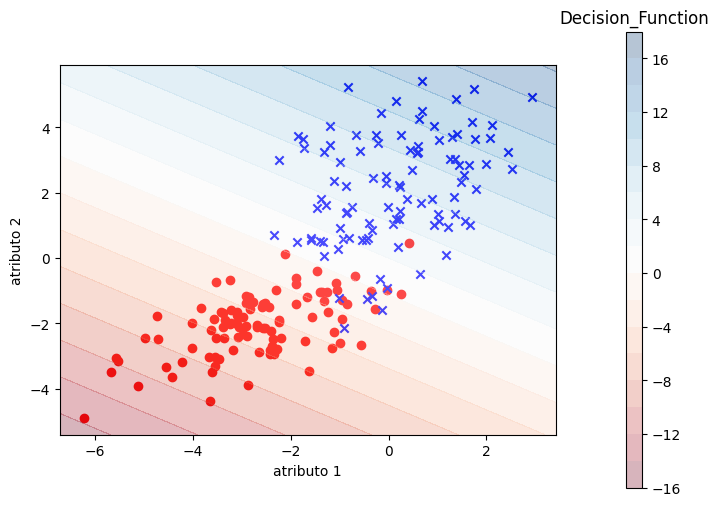

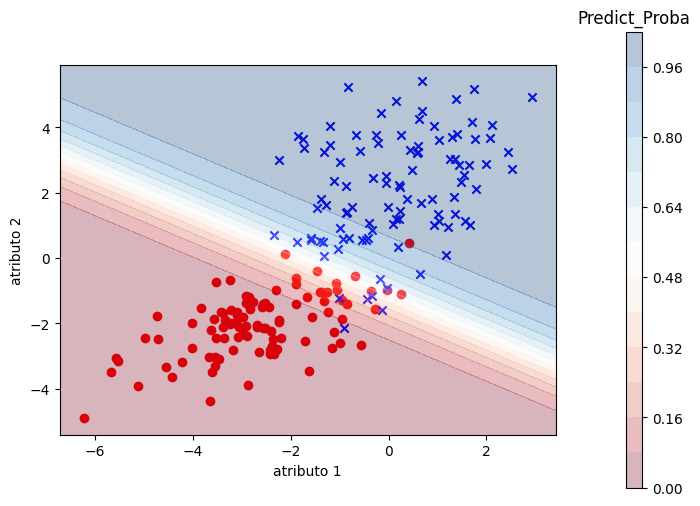

In [9]:
from sklearn.linear_model import LogisticRegression
cla = LogisticRegression()
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)
plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

# Ejercicio 5

- Realice una comparación gráfica utilizando el método `my_plot_biclassifier` de los clasificadores vistos en este cuaderno sobre la base de datos [half moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html). Discuta sobre las fronteras estimadas por cada modelo.

In [10]:
#Ayuda de código
from sklearn.datasets import make_moons
N = 200
X,y = make_moons(N,noise=0.2)#las etiquetas en y valen 0 o 1
#se ajustan etiqueta a valores -1 y +1 según método definido para visualizar fronteras
y[y==0] = -1

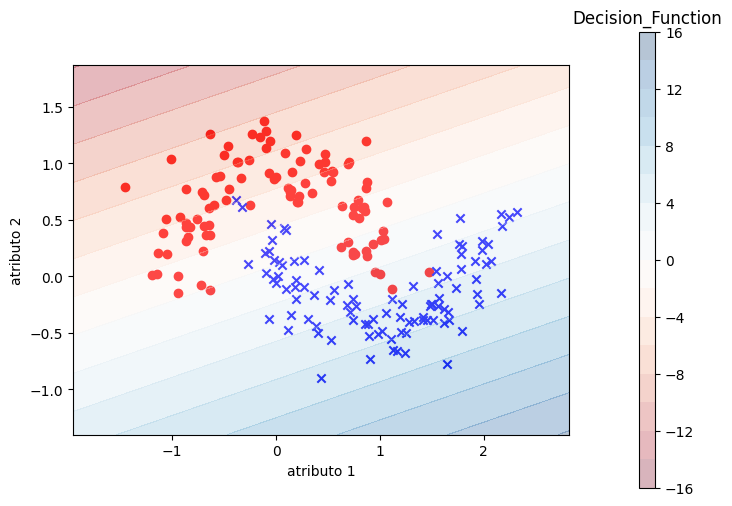

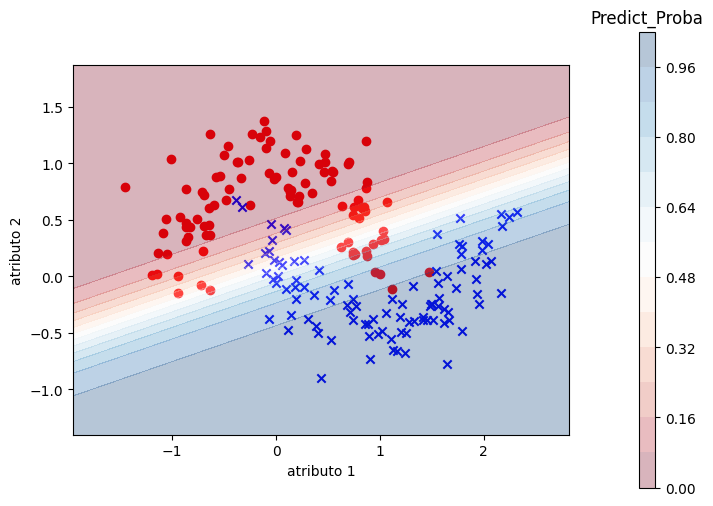

In [11]:
#clasificador naive bayes
cla = LinearDiscriminantAnalysis()
cla.fit(X,y)
my_plot_biclassifier(cla,X,y)

plt.title('Decision_Function')
plt.show()

my_plot_biclassifier(cla,X,y,score_type='predict_proba')
plt.title('Predict_Proba')
plt.show()

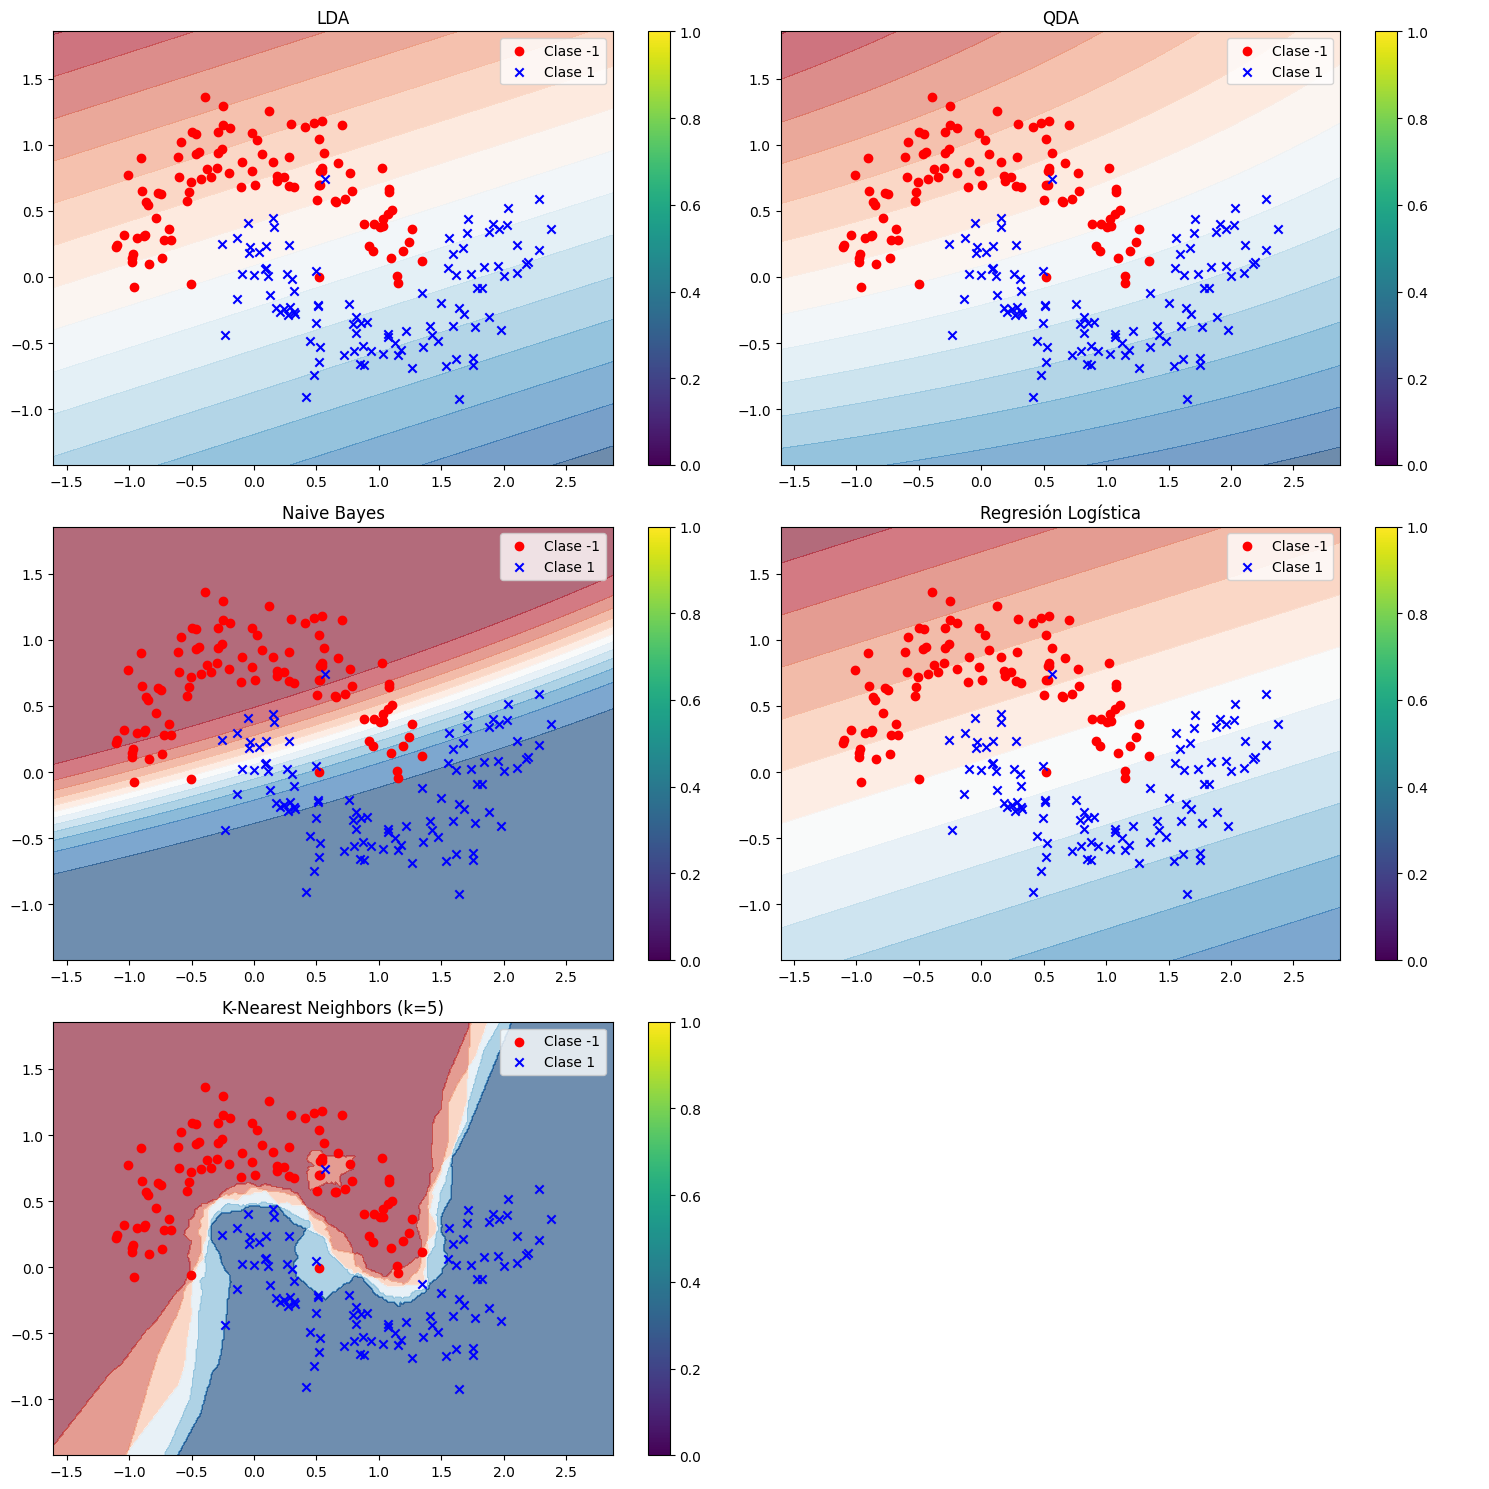

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Generar el conjunto de datos half moons
N = 200
X, y = make_moons(N, noise=0.2)
y[y == 0] = -1  # Ajustar las etiquetas para que sean -1 y +1

# Definir los clasificadores a comparar
classifiers = {
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Regresión Logística': LogisticRegression(),
    'K-Nearest Neighbors (k=5)': KNeighborsClassifier(n_neighbors=5)
}

# Función para graficar la frontera de decisión
def my_plot_biclassifier(model, X, y, levels=15, h=0.01, score_type="decision_function"):
    # Crear un grid sobre el espacio de atributos
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Calcular el score de decisión o probabilidad
    if score_type == "predict_proba":
        if hasattr(model, 'predict_proba'):
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        else:
            Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        if hasattr(model, 'decision_function'):
            Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    Z = Z.reshape(xx.shape)

    # Graficar el contorno relleno
    plt.contourf(xx, yy, Z, levels=levels, cmap=plt.cm.RdBu, alpha=0.6)

    # Graficar los datos originales
    plt.scatter(X[y == -1, 0], X[y == -1, 1], c='red', marker='o', label='Clase -1')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', marker='x', label='Clase 1')
    plt.legend()
    plt.colorbar()  # Añadir barra de color para ver los valores de probabilidad o score

# Crear un gráfico con subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

# Entrenar y graficar cada clasificador
for i, (name, clf) in enumerate(classifiers.items()):
    clf.fit(X, y)
    plt.sca(axes[i])
    plt.title(name)
    my_plot_biclassifier(clf, X, y)

# Ocultar el subplot extra
axes[-1].axis('off')

plt.tight_layout()
plt.show()


# Discusión sobre las fronteras estimadas por cada modelo

A continuación, se discute el comportamiento de los diferentes clasificadores en el conjunto de datos "half moons", basándose en las fronteras de decisión graficadas.

## 1. **LDA (Linear Discriminant Analysis)**
   - **Frontera de decisión**: Lineal.
   - **Explicación**: LDA asume que las clases tienen distribuciones Gaussianas con la misma matriz de covarianza. Esto impone una frontera de decisión lineal, ya que el modelo separa las clases basándose en una proyección lineal de los datos.
   - **Observación**: Dado que los datos del conjunto "half moons" no son linealmente separables, el LDA no es capaz de capturar adecuadamente la forma curva de la frontera entre las dos clases, lo que lleva a una clasificación deficiente en las áreas más cercanas a la intersección de las medias lunas.

## 2. **QDA (Quadratic Discriminant Analysis)**
   - **Frontera de decisión**: Cuadrática.
   - **Explicación**: A diferencia de LDA, QDA permite que las clases tengan diferentes matrices de covarianza, lo que genera una frontera de decisión cuadrática. Esto proporciona mayor flexibilidad para capturar relaciones no lineales entre las clases.
   - **Observación**: En este caso, aunque la frontera de QDA es más flexible que la de LDA, todavía no se ajusta perfectamente a la curva característica de las medias lunas. La frontera es más suave que la de LDA, pero sigue siendo insuficiente para capturar completamente la forma compleja de los datos.

## 3. **Naive Bayes (GaussianNB)**
   - **Frontera de decisión**: Moderadamente curva.
   - **Explicación**: Naive Bayes asume que las características son independientes y siguen una distribución Gaussiana. Debido a esta suposición de independencia, la frontera generada tiende a ser menos flexible y algo más rígida, pero puede tener una curvatura ligera en ciertos casos.
   - **Observación**: En este caso, la frontera de decisión de Naive Bayes es algo curva, lo que le permite clasificar correctamente una mayor cantidad de puntos en comparación con LDA, pero sigue sin ser lo suficientemente compleja como para ajustarse a la estructura de las medias lunas.

## 4. **Regresión Logística**
   - **Frontera de decisión**: Lineal.
   - **Explicación**: La regresión logística es un modelo lineal que asume que los datos son separables por una frontera lineal. Utiliza la función sigmoide para calcular la probabilidad de pertenencia a una clase y establece una frontera entre las dos clases.
   - **Observación**: Al igual que LDA, la frontera de decisión es lineal, por lo que no puede capturar la estructura curva de las medias lunas. Esto da lugar a una clasificación errónea de los puntos cercanos a la intersección de las medias lunas, donde la linealidad no es suficiente.

## 5. **K-Nearest Neighbors (KNN, k=5)**
   - **Frontera de decisión**: No lineal, altamente flexible.
   - **Explicación**: KNN es un clasificador no paramétrico que basa sus predicciones en la proximidad de los puntos en el espacio de características. La frontera de decisión depende directamente de la distribución de los datos y de la cantidad de vecinos considerados.
   - **Observación**: En este caso, KNN genera una frontera de decisión altamente no lineal, lo que le permite ajustarse bien a la forma curva de los datos "half moons". Esto hace que KNN sea el clasificador más adecuado para este conjunto de datos, capturando con precisión la relación compleja entre las dos clases.

## **Conclusión**
- **LDA** y **Regresión Logística** no son adecuados para este conjunto de datos debido a su restricción de fronteras lineales, lo que limita su capacidad para capturar la estructura no lineal de las medias lunas.
- **QDA** y **Naive Bayes** son algo mejores que los modelos lineales, ya que pueden generar fronteras más flexibles, pero aún no logran capturar completamente la complejidad de los datos.
- **KNN** es el modelo más adecuado en este caso, ya que produce una frontera de decisión no lineal que sigue de cerca la estructura real de las medias lunas, lo que le permite clasificar los puntos de manera más precisa.
